## **Reading the Dataset as a DataFrame**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Final Year Paper Work/Complete Summarized Dataset.xlsx', header=0,index_col=0)

df = df.dropna() # To remove any None values
df.head()

,Judgement,Domain,Judgement Status,Court,Abstractive Summarized Judgements,Extractive Summarized Judgements
Id,,,,,,
1,"""This was an appeal from a judgment and decree...",Civil,1,Supreme Court,In order to enforce war-time controls another ...,"According to the Respondent, on the 11th Augus..."
2,"""This was an application under article 32 (1) ...",Civil,2,Supreme Court,The second part of this bye-law clearly contem...,This is an application under article 32 of the...
3,"""APPEAL from a judgment of the High Court of H...",Civil,0,Supreme Court,The learned advocate for the appellant contend...,749 The sole point for determination in the ap...
4,"""APPEAL under article 374(4) of the Constituti...",Civil,0,Supreme Court,It has been held that the first appellate cour...,This objection was overruled by the court and ...
5,"""Petitions under Art. 136 of the Constitution ...",Criminal,3,Supreme Court,It was pointed out that in respect of convicti...,The petitioners have now filed their petitions...


##**Splitting the data for complete, extractive and abstractive summarized texts**

In [ ]:
# Complete Data
com_sentences = df[['Judgement','Judgement Status']]

# Abstractive Data
abs_sentences = df[['Abstractive Summarized Judgements','Judgement Status']]

# Extractive Data
ext_sentences = df[['Extractive Summarized Judgements','Judgement Status']]

from sklearn.model_selection import train_test_split

# Train and Test Split for Complete Data
df_train_com, df_test_com = train_test_split(com_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Abstractive Data
df_train_abs, df_test_abs = train_test_split(abs_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Extractive Data
df_train_ext, df_test_ext = train_test_split(ext_sentences, test_size=0.25, random_state=42)

## **Converting the Judgement Status to Categorical Values**

In [ ]:
from tensorflow.keras.utils import to_categorical

# Complete Data
y_train_com = to_categorical(df_train_com['Judgement Status'])
y_test_com = to_categorical(df_test_com['Judgement Status'])

# Abstractive Data
y_train_abs = to_categorical(df_train_abs['Judgement Status'])
y_test_abs = to_categorical(df_test_abs['Judgement Status'])

# Extractive Data
y_train_ext = to_categorical(df_train_ext['Judgement Status'])
y_test_ext = to_categorical(df_test_ext['Judgement Status'])

## **Import Statements**

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.3 MB/s eta 0:00:00


In [ ]:
# Import Statements
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
import transformers
from transformers import AutoTokenizer, TFBertModel

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

##**1) Complete Data**

In [ ]:
# Tokenize the input (takes some time)
# Here, tokenizer used is from bert-base-cased
x_train_com_bert = bert_tokenizer(
    text=df_train_com['Judgement'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_com_bert = bert_tokenizer(
    text=df_test_com['Judgement'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_com_bert = x_train_com_bert['input_ids']
attention_mask_com_bert = x_train_com_bert['attention_mask']

In [ ]:
# BERT Architecture
max_len = 100
input_ids_com_bert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_com_bert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids_com_bert, attention_mask = input_mask_com_bert)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model_com_bert = tf.keras.Model(inputs=[input_ids_com_bert, input_mask_com_bert], outputs=y)
model_com_bert.layers[2].trainable = True

In [ ]:
optimizer_bert = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_bert = CategoricalCrossentropy(from_logits = True)
metric_bert = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model_com_bert.compile(
    optimizer = optimizer_bert,
    loss=loss_bert,
    metrics = metric_bert)
model_com_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                       

In [ ]:
history_com_bert = model_com_bert.fit(
    x ={'input_ids':x_train_com_bert['input_ids'],'attention_mask':x_train_com_bert['attention_mask']} ,
    y = y_train_com,
    validation_data = (
    {'input_ids':x_test_com_bert['input_ids'],'attention_mask':x_test_com_bert['attention_mask']}, y_test_com
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 62s 2s/step - loss: 1.5306 - balanced_accuracy: 0.2838 - val_loss: 1.3470 - val_balanced_accuracy: 0.3154
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 1.3030 - balanced_accuracy: 0.3716 - val_loss: 1.3080 - val_balanced_accuracy: 0.3826
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 1.1582 - balanced_accuracy: 0.5405 - val_loss: 1.2440 - val_balanced_accuracy: 0.3893
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 1.0079 - balanced_accuracy: 0.6239 - val_loss: 1.1951 - val_balanced_accuracy: 0.3893
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.8734 - balanced_accuracy: 0.6532 - val_loss: 1.2226 - val_balanced_accuracy: 0.3624
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.7553 - balanced_accuracy: 0.7342 - val_loss: 1.1972 - val_balanced_accuracy: 0.4362
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.6325 - ba

In [ ]:
predicted_raw_com_bert = model_com_bert.predict({'input_ids':x_test_com_bert['input_ids'],'attention_mask':x_test_com_bert['attention_mask']})
predicted_raw_com_bert[0]

5/5 [==============================] - 4s 181ms/step


array([0.937583  , 0.89303553, 0.03454865, 0.04346972], dtype=float32)

In [ ]:
import numpy as np

y_predicted_com_bert = np.argmax(predicted_raw_com_bert, axis = 1)
y_true_com_bert = df_test_com['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_com_bert, y_predicted_com_bert))

print("F1 Score: ",f1_score(y_true_com_bert,y_predicted_com_bert, average='macro'))

              precision    recall  f1-score   support

           0       0.47      0.41      0.44        39
           1       0.47      0.53      0.50        45
           2       0.38      0.55      0.45        29
           3       0.32      0.19      0.24        36

    accuracy                           0.42       149
   macro avg       0.41      0.42      0.41       149
weighted avg       0.42      0.42      0.41       149

F1 Score:  0.4076099250201255


In [ ]:
x_train_com_bert = {'input_ids':x_train_com_bert['input_ids'],'attention_mask':x_train_com_bert['attention_mask']}

train_loss_com_bert, train_accuracy_com_bert = model_com_bert.evaluate(x_train_com_bert, y_train_com, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_com_bert))

Training Accuracy: 0.9887


In [ ]:
x_test_com_bert = {'input_ids':x_test_com_bert['input_ids'],'attention_mask':x_test_com_bert['attention_mask']}

test_loss_com_bert, test_accuracy_com_bert = model_com_bert.evaluate(x_test_com_bert, y_test_com, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_com_bert))

Testing Accuracy:  0.4228


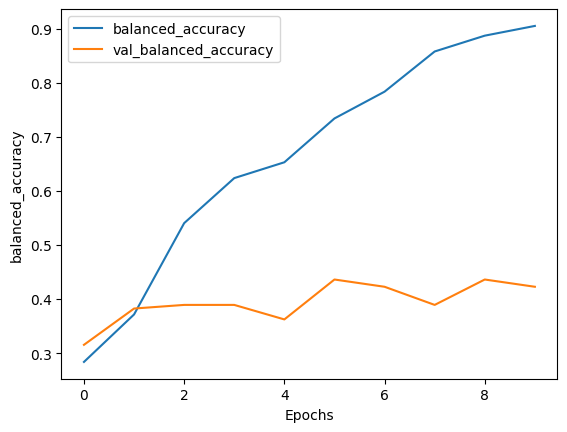

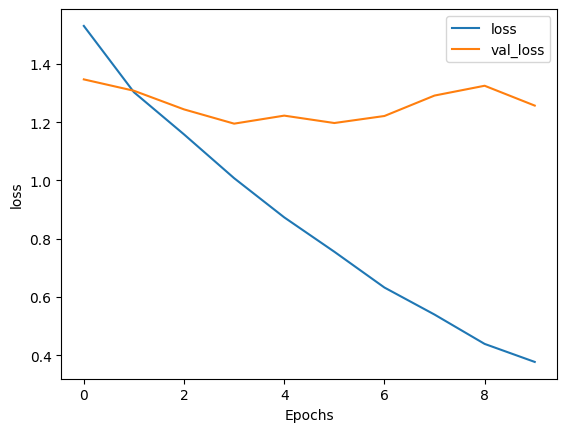

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_com_bert, "balanced_accuracy")
plot_graphs(history_com_bert, "loss")

In [ ]:
model_com_bert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/COM-BERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd

# Calculate the "Model Outcome" based on the predicted values and actual "Judgement Status"
y_predicted_com_bert = np.argmax(predicted_raw_com_bert, axis=1)
model_outcome_bert = [1 if predicted == actual else 0 for predicted, actual in zip(y_predicted_com_bert, y_true_com_bert)]

# Create a new DataFrame with "Judgements" and "Model Outcome" columns
results_df_com_bert = pd.DataFrame({'Judgements': df_test_com['Judgement'], 'Model Outcome': model_outcome_bert})

# Save the DataFrame to a CSV file if needed
results_df_com_bert.to_csv('model_results.csv', index=False)

##**2) Abstractive Summarized Data**


In [ ]:
# Tokenize the input (takes some time)
# Here, tokenizer used is from bert-base-cased
x_train_abs_bert = bert_tokenizer(
    text=df_train_abs['Abstractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_abs_bert = bert_tokenizer(
    text=df_test_abs['Abstractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_abs_bert = x_train_abs_bert['input_ids']
attention_mask_abs_bert = x_train_abs_bert['attention_mask']

In [ ]:
# BERT Architecture
max_len = 100
input_ids_abs_bert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_abs_bert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids_abs_bert, attention_mask = input_mask_abs_bert)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model_abs_bert = tf.keras.Model(inputs=[input_ids_abs_bert, input_mask_abs_bert], outputs=y)
model_abs_bert.layers[2].trainable = True

In [ ]:
optimizer_bert = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_bert = CategoricalCrossentropy(from_logits = True)
metric_bert = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model_abs_bert.compile(
    optimizer = optimizer_bert,
    loss=loss_bert,
    metrics = metric_bert)
model_abs_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                     

In [ ]:
history_abs_bert = model_abs_bert.fit(
    x ={'input_ids':x_train_abs_bert['input_ids'],'attention_mask':x_train_abs_bert['attention_mask']} ,
    y = y_train_abs,
    validation_data = (
    {'input_ids':x_test_abs_bert['input_ids'],'attention_mask':x_test_abs_bert['attention_mask']}, y_test_abs
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 35s 2s/step - loss: 1.5657 - balanced_accuracy: 0.2793 - val_loss: 1.4143 - val_balanced_accuracy: 0.3289
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 1.3657 - balanced_accuracy: 0.3153 - val_loss: 1.3089 - val_balanced_accuracy: 0.3356
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 1.2473 - balanced_accuracy: 0.4167 - val_loss: 1.2677 - val_balanced_accuracy: 0.4027
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 1.1237 - balanced_accuracy: 0.5315 - val_loss: 1.2503 - val_balanced_accuracy: 0.4161
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.9407 - balanced_accuracy: 0.6554 - val_loss: 1.2500 - val_balanced_accuracy: 0.4027
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.7928 - balanced_accuracy: 0.7387 - val_loss: 1.2877 - val_balanced_accuracy: 0.4094
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.6665 - ba

In [ ]:
predicted_raw_abs_bert = model_abs_bert.predict({'input_ids':x_test_abs_bert['input_ids'],'attention_mask':x_test_abs_bert['attention_mask']})
predicted_raw_abs_bert[0]

5/5 [==============================] - 8s 187ms/step


array([0.8234289 , 0.70878196, 0.30790356, 0.36570793], dtype=float32)

In [ ]:
import numpy as np

y_predicted_abs_bert = np.argmax(predicted_raw_abs_bert, axis = 1)
y_true_abs_bert = df_test_abs['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_abs_bert, y_predicted_abs_bert))

print("F1 Score: ",f1_score(y_true_abs_bert,y_predicted_abs_bert, average='macro'))

              precision    recall  f1-score   support

           0       0.36      0.41      0.39        39
           1       0.42      0.36      0.39        45
           2       0.37      0.59      0.45        29
           3       0.29      0.17      0.21        36

    accuracy                           0.37       149
   macro avg       0.36      0.38      0.36       149
weighted avg       0.36      0.37      0.36       149

F1 Score:  0.35873599661805117


In [ ]:
x_train_abs_bert = {'input_ids':x_train_abs_bert['input_ids'],'attention_mask':x_train_abs_bert['attention_mask']}

train_loss_abs_bert, train_accuracy_abs_bert = model_abs_bert.evaluate(x_train_abs_bert, y_train_abs, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_abs_bert))

Training Accuracy: 0.9977


In [ ]:
x_test_abs_bert = {'input_ids':x_test_abs_bert['input_ids'],'attention_mask':x_test_abs_bert['attention_mask']}

test_loss_abs_bert, test_accuracy_abs_bert = model_abs_bert.evaluate(x_test_abs_bert, y_test_abs, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_abs_bert))

Testing Accuracy:  0.3691


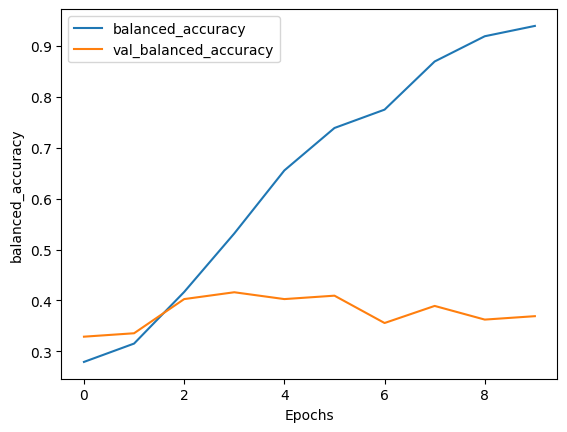

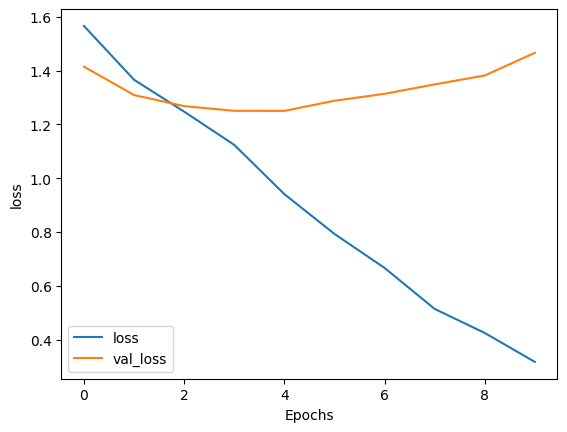

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_abs_bert, "balanced_accuracy")
plot_graphs(history_abs_bert, "loss")

In [ ]:
model_abs_bert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/ABS-BERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **3) Extractive Summarized Data**

In [ ]:
# Tokenize the input (takes some time)
# Here, tokenizer used is from bert-base-cased
x_train_ext_bert = bert_tokenizer(
    text=df_train_ext['Extractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_ext_bert = bert_tokenizer(
    text=df_test_ext['Extractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_ext_bert = x_train_ext_bert['input_ids']
attention_mask_ext_bert = x_train_ext_bert['attention_mask']

In [ ]:
# BERT Architecture
max_len = 100
input_ids_ext_bert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_ext_bert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids_ext_bert, attention_mask = input_mask_ext_bert)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model_ext_bert = tf.keras.Model(inputs=[input_ids_ext_bert, input_mask_ext_bert], outputs=y)
model_ext_bert.layers[2].trainable = True

In [ ]:
optimizer_bert = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_bert = CategoricalCrossentropy(from_logits = True)
metric_bert = CategoricalAccuracy('balanced_accuracy')

# extpile the model
model_ext_bert.compile(
    optimizer = optimizer_bert,
    loss=loss_bert,
    metrics = metric_bert)
model_ext_bert.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                     

In [ ]:
history_ext_bert = model_ext_bert.fit(
    x ={'input_ids':x_train_ext_bert['input_ids'],'attention_mask':x_train_ext_bert['attention_mask']} ,
    y = y_train_ext,
    validation_data = (
    {'input_ids':x_test_ext_bert['input_ids'],'attention_mask':x_test_ext_bert['attention_mask']}, y_test_ext
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 36s 2s/step - loss: 1.5819 - balanced_accuracy: 0.3131 - val_loss: 1.2354 - val_balanced_accuracy: 0.4094
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 1.1526 - balanced_accuracy: 0.4730 - val_loss: 1.1743 - val_balanced_accuracy: 0.4295
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.9443 - balanced_accuracy: 0.5766 - val_loss: 1.1984 - val_balanced_accuracy: 0.4430
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.7966 - balanced_accuracy: 0.6914 - val_loss: 1.2104 - val_balanced_accuracy: 0.4698
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.6234 - balanced_accuracy: 0.7860 - val_loss: 1.3532 - val_balanced_accuracy: 0.4631
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.4555 - balanced_accuracy: 0.8761 - val_loss: 1.3752 - val_balanced_accuracy: 0.4027
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.3563 - ba

In [ ]:
predicted_raw_ext_bert = model_ext_bert.predict({'input_ids':x_test_ext_bert['input_ids'],'attention_mask':x_test_ext_bert['attention_mask']})
predicted_raw_ext_bert[0]

5/5 [==============================] - 5s 196ms/step


array([0.19684982, 0.99352866, 0.0146219 , 0.0405565 ], dtype=float32)

In [ ]:
import numpy as np

y_predicted_ext_bert = np.argmax(predicted_raw_ext_bert, axis = 1)
y_true_ext_bert = df_test_ext['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_ext_bert, y_predicted_ext_bert))

print("F1 Score: ",f1_score(y_true_ext_bert,y_predicted_ext_bert, average='macro'))

              precision    recall  f1-score   support

           0       0.23      0.28      0.26        39
           1       0.45      0.49      0.47        45
           2       0.55      0.41      0.47        29
           3       0.52      0.44      0.48        36

    accuracy                           0.41       149
   macro avg       0.44      0.41      0.42       149
weighted avg       0.43      0.41      0.42       149

F1 Score:  0.418024808865994


In [ ]:
x_train_ext_bert = {'input_ids':x_train_ext_bert['input_ids'],'attention_mask':x_train_ext_bert['attention_mask']}

train_loss_ext_bert, train_accuracy_ext_bert = model_ext_bert.evaluate(x_train_ext_bert, y_train_ext, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_ext_bert))

Training Accuracy: 0.9955


In [ ]:
x_test_ext_bert = {'input_ids':x_test_ext_bert['input_ids'],'attention_mask':x_test_ext_bert['attention_mask']}

test_loss_ext_bert, test_accuracy_ext_bert = model_ext_bert.evaluate(x_test_ext_bert, y_test_ext, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_ext_bert))

Testing Accuracy:  0.4094


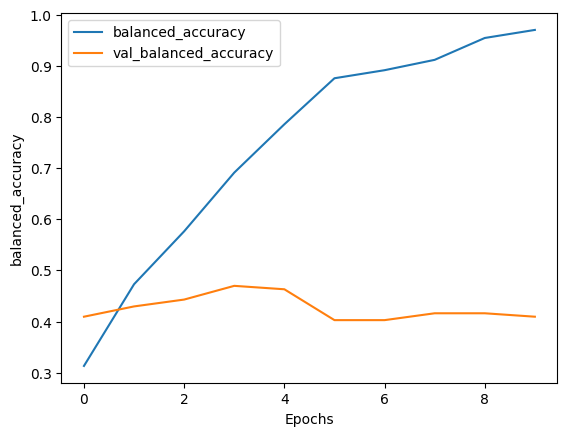

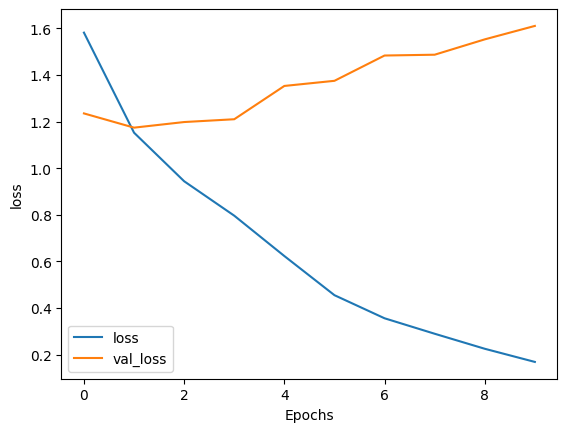

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_ext_bert, "balanced_accuracy")
plot_graphs(history_ext_bert, "loss")

In [ ]:
model_ext_bert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/EXT-BERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
